In [95]:
import numpy as np
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sbn
from pycocotools.coco import COCO
import cv2
import random
import matplotlib.patches as patches

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip "/content/drive/MyDrive/PPEs.v4-raw.coco.zip"

# 1. Zapoznanie z danymi



Ścieżki do adnotacji zapisanych w pliku JSON oraz do folderu ze zdjęciami.

In [ ]:
annotations_file = "/content/train/_annotations.coco.json"
images_directory = "/content/train"

## 1.1 Pliki w standardzie COCO

https://docs.aws.amazon.com/rekognition/latest/customlabels-dg/md-coco-overview.html

Plik JSON w standardzie COCO podzielony jest najpierw na:
*   info
*   licenses
*   categories
*   images
*   annotations

Pózniej kolejno jak poniżej:


```
"info": {
        "year": "2022",
        "version": "4",
        "description": "Exported from roboflow.ai",
        "contributor": "",
        "url": "https://public.roboflow.ai/object-detection/undefined",
        "date_created": "2022-03-17T15:35:23+00:00"
    },
"licenses": [
        {
            "id": 1,
            "url": "https://creativecommons.org/licenses/by/4.0/",
            "name": "CC BY 4.0"
        }
],
"categories": [
        {
            "id": 0,
            "name": "ppe-equipements",
            "supercategory": "none"
        },
        {
            "id": 1,
            "name": "glove",
            "supercategory": "ppe-equipements"
        },...
],
"images": [
        {
            "id": 0,
            "license": 1,
            "file_name": "packing797_jpg.rf.27b43e324bbe7f94c3a0c3c821fa8e6a.jpg",
            "height": 720,
            "width": 1280,
            "date_captured": "2022-03-17T15:35:23+00:00"
        },...
],
"annotations": [
        {
            "id": 0,
            "image_id": 0,
            "category_id": 2,
            "bbox": [
                905,
                204,
                79,
                38
            ],
            "area": 3002,
            "segmentation": [],
            "iscrowd": 0
        },...
]
```



## 1.2 Ładowanie zbioru danych

Do załadowania zbioru danych do analizy w tej formie można się męczyć i sparsować plik JSON ręcznie (przy użyciu kodu oczywiście) lub użyć COCO API.
Przykład użycia z oryginalnych docsów:
https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

In [ ]:
# https://github.com/ppwwyyxx/cocoapi
# fork cocoapi -> naprawione błędy, więcej opcji
coco = COCO(annotations_file)

loading annotations into memory...
Done (t=0.34s)
creating index...
index created!


## 1.3 Zapoznanie się z danymi i ich charakterystyką

### Ilość zdjęć

In [ ]:
num_images = len(coco.getImgIds()) # ilość obrazów
print(num_images)

9611


### Klasy

In [ ]:
category_ids = coco.getCatIds()

In [ ]:
def get_object_names(category_ids):
    object_names = []
    for category_id in category_ids:
        category_info = coco.loadCats(category_id)[0]
        object_names.append(category_info['name'])
    return object_names

In [ ]:
id_to_category = get_object_names(category_ids)

print(len(id_to_category) - 1)
print(id_to_category)

12
['ppe-equipements', 'glove', 'goggles', 'helmet', 'mask', 'no-suit', 'no_glove', 'no_goggles', 'no_helmet', 'no_mask', 'no_shoes', 'shoes', 'suit']


### Wyświetlanie przykładowych zdjęć z opisanymi zaznaczeniami

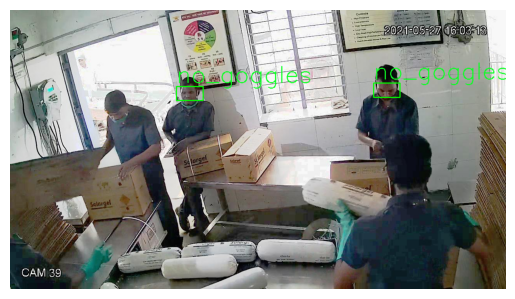

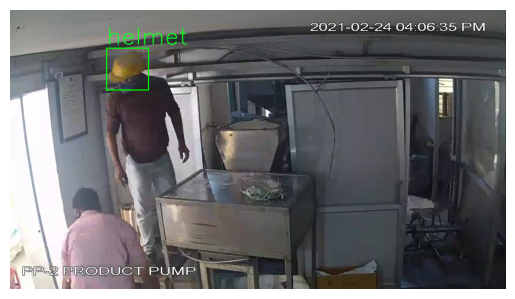

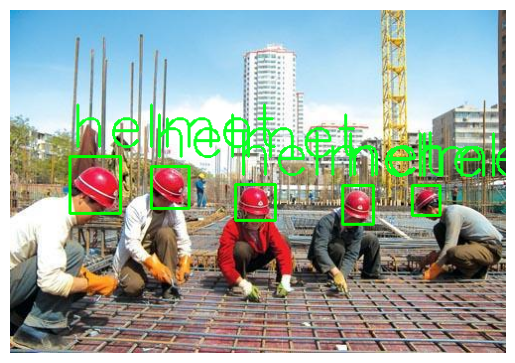

In [ ]:
random_image_ids = random.sample(range(0, num_images), 3) # generuje n losowych ID od 0 do num_images - 1


for id in random_image_ids: # iteruje przez wszystkie losowo wygenerowane id
  # info na temat adnotacji oraz ścieżka do wyświetlenia obrazu
  image_id = coco.loadImgs(id)[0]["id"]
  image_file_name = coco.loadImgs(id)[0]["file_name"]
  image_path = os.path.join(images_directory, image_file_name)
  image = cv2.imread(image_path)


  annotation_ids = coco.getAnnIds(imgIds = image_id, catIds = category_ids) # zwraca listę id adnotacji
  annotations = coco.loadAnns(annotation_ids) # zwraca listę dictów zawierających info na temat danej adnotacji
  for annotation in annotations:
    bbox = annotation["bbox"]

    category_id = annotation["category_id"] # 0, 1, ...
    category_str = id_to_category[category_id] # glove, goggles, ...

    cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])), (0, 255, 0), 2) # nakłada bounding box na obraz

    cv2.putText(image, category_str, (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (36,255,12), 2) # podpisuje box odpowiednią kategorią

  # wyświetla obraz z bboxami
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

# 2. Wizualizacja i wstępna analiza

## 2.1 Klasy - ilość oraz balans

In [ ]:
objects_count = {key : 0 for key in id_to_category[1:]}

In [ ]:
for annotation in coco.dataset["annotations"]:
    category_id = annotation["category_id"]
    category_str = id_to_category[category_id]

    objects_count[category_str] += 1
print(objects_count)

{'glove': 3705, 'goggles': 3361, 'helmet': 1240, 'mask': 211, 'no-suit': 248, 'no_glove': 4885, 'no_goggles': 3293, 'no_helmet': 1067, 'no_mask': 524, 'no_shoes': 463, 'shoes': 570, 'suit': 121}


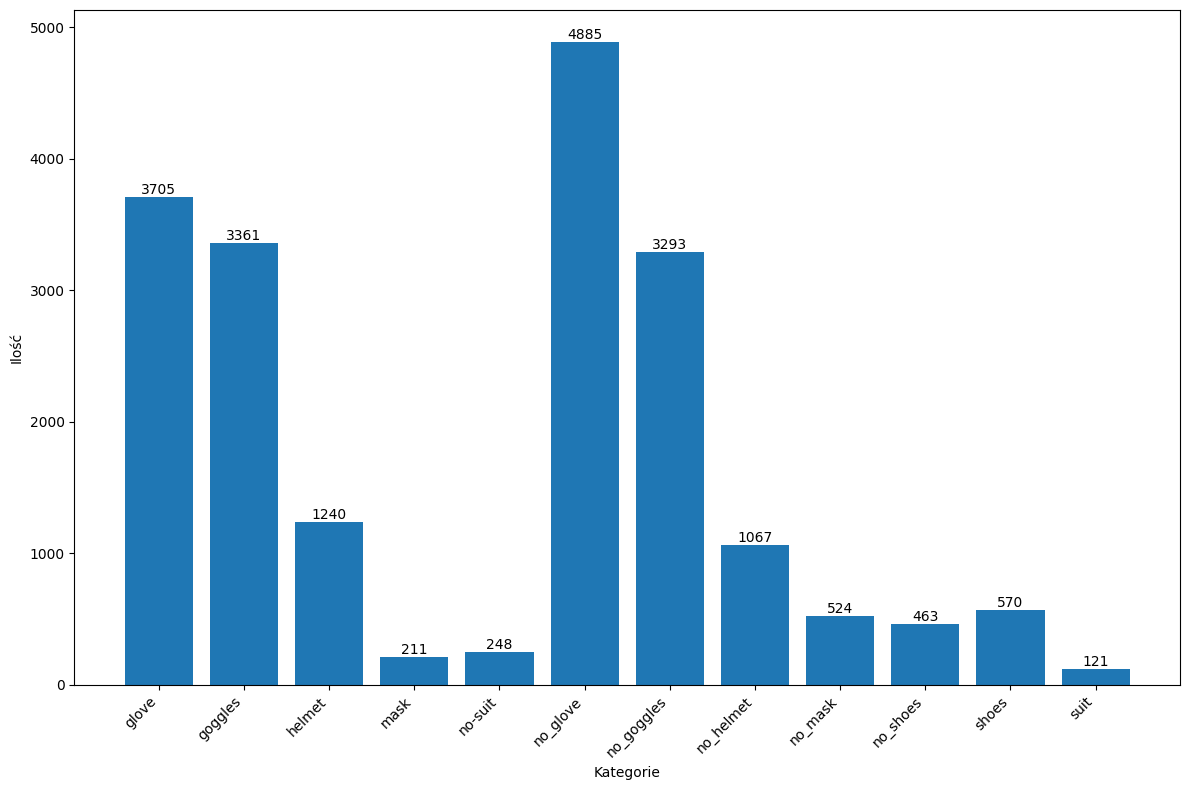

In [ ]:
categories = list(objects_count.keys())
counts = list(objects_count.values())

# https://matplotlib.org/stable/tutorials/pyplot.html

plt.figure(figsize=(12, 8))
plt.bar(categories, counts)
plt.xlabel("Kategorie")
plt.ylabel("Ilość")
plt.title("")

plt.xticks(rotation=45, ha='right')

for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Fakty
* Zbiór danych jest bardzo niezbalansowany. Niektóre klasy występują znacznie częściej niż inne.
* Klasy "glove", "no_glove", "goggles" i "no_goggles" są najbardziej liczne. Model, który zostanie poddany treningowi z taką dysproporcją klas może być obciążony *(ang. biased)* i będzię miał skłonność do dużo lepszego wykrywania klas częściej występujących w zbiorze treningowym.
* Analogicznie klasy rzadziej występujące, takie jak: "mask", "suit" i "shoes" oraz ich przeciwieństwa będą dużo gorzej wykrywane przez model.
* Podczas ręcznej inspekcji kilku zdjęć zwróciłem uwagę na niekonsekwencję przy ich opisie. Na niektórych obrazach widoczne jest kilka klas, jednak nie wszystkie zostały opisane. Może to prowadzić do kilku problemów. Model może nie nauczyć się rozpoznawać klas, które są najczęściej pomijane przy opisie zdjęć. Tracimy w ten sposób również wiele cennych przykładów, z których model mógłby potencjalnie wiele wynieść. Jeżeli taka sama sytuacja ma miejce w zbiorze danych służącym do walidacji *(ang. validation dataset)* nie będzie możliwa właściwa ocena wydajności modelu, np. model wielekrotnie nie wykryje kasku na głowie pracownika, a przez to że nie został on opisany nawet nie będziemy wiedzieli o takim problemie.

### Możliwe ulepszenia
* Nalepszym rozwiązaniem jest zebranie większej ilości danych. W szczególności należy skupić się na pozyskaniu klas, które znacząco odstają od innych pod względem liczebności. Należy pamiętać również o zachowaniu balansu w ilości pomiędzy klasą i jej zaprzeczeniem, tzn. gdy pozyskamy dodatkowe 500 przykładów klasy "suit", w idealnym przypadku powinniśmy także zebrać dodatkowe 500 przykładów klasy "no_suit".
* Kolejną opcją (lub dodatkową) jest zastosowanie sztucznego generowania nowych danych *(ang. data augmentation)*. Możliwości jest wiele - tworzenie lustrzanych odbić, zmiania kontrastu, zmiana tła w programie graficznym, częściowe przysłonienie klas w programie graficznym.
* Jedynym rozwiązaniem na całkowite wyeliminowanie problemów związanych z niekonsekwencją przy opisie danych jest ich poprawienie. Można spróbować tworzyć model bez ich poprawy, ale wtedy trzeba liczyć się z niższą wydajnością (która jendak może okazać się wystarczająca).

## 2.2 Rozmiary zdjęć

In [ ]:
image_count_by_size = dict()

In [ ]:
for image in coco.dataset["images"]:
  image_size = (image["height"], image["width"])
  image_count_by_size[image_size] = image_count_by_size.get(image_size, 0) + 1

In [ ]:
print(image_count_by_size)

{(720, 1280): 7813, (1520, 2688): 339, (1536, 2048): 1195, (1080, 1920): 49, (333, 500): 49, (306, 500): 1, (300, 534): 5, (375, 500): 18, (329, 500): 3, (358, 500): 1, (225, 300): 1, (350, 499): 1, (307, 410): 1, (266, 400): 3, (334, 500): 16, (346, 500): 1, (309, 500): 2, (320, 480): 2, (328, 500): 2, (262, 350): 1, (275, 400): 1, (332, 500): 7, (300, 399): 1, (328, 490): 1, (368, 500): 2, (300, 450): 9, (338, 500): 2, (390, 500): 2, (378, 500): 1, (350, 500): 1, (347, 500): 1, (265, 400): 1, (337, 500): 1, (959, 640): 1, (300, 533): 1, (380, 500): 2, (269, 400): 1, (335, 500): 2, (300, 502): 1, (325, 500): 1, (352, 500): 1, (354, 500): 1, (299, 450): 1, (500, 375): 1, (426, 640): 2, (300, 400): 4, (309, 450): 1, (268, 400): 1, (374, 500): 2, (348, 500): 1, (200, 300): 1, (366, 500): 1, (311, 500): 2, (414, 300): 1, (318, 500): 1, (398, 475): 1, (267, 400): 1, (295, 450): 1, (400, 600): 2, (330, 500): 1, (300, 451): 1, (430, 496): 1, (326, 500): 2, (270, 359): 1, (323, 500): 2, (667,

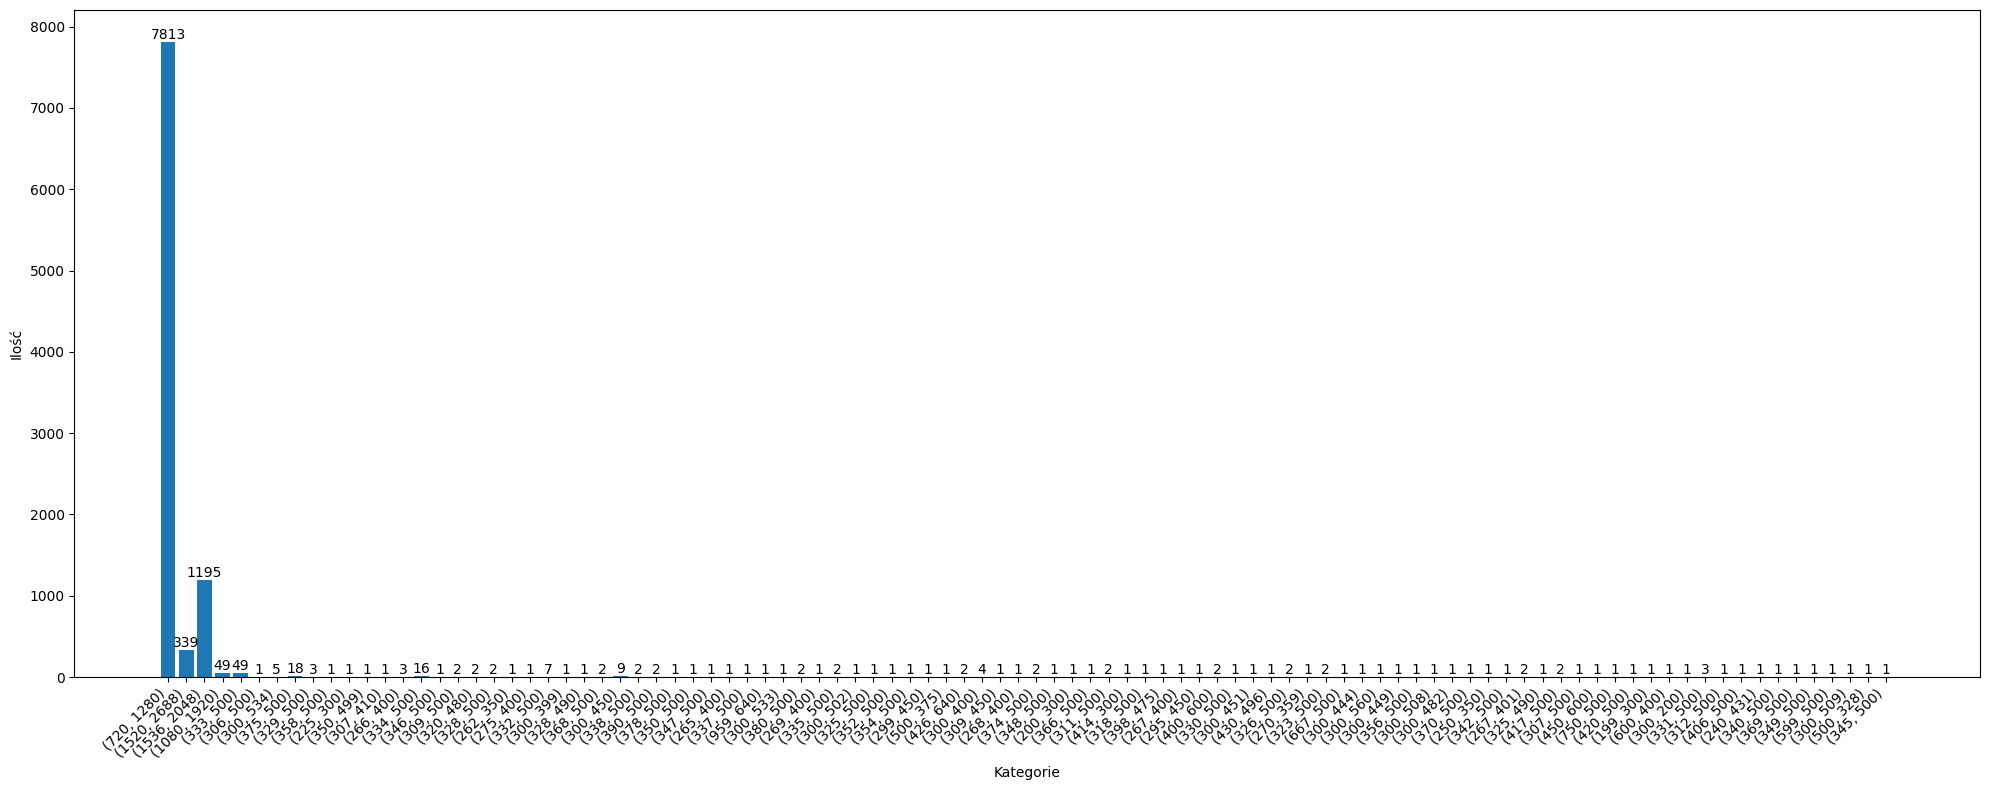

In [ ]:
categories = list(str(size) for size in image_count_by_size.keys())
counts = list(image_count_by_size.values())

plt.figure(figsize=(20, 8))
plt.bar(categories, counts)
plt.xlabel("Kategorie")
plt.ylabel("Ilość")
plt.title("")


plt.xticks(rotation=45, ha='right')

for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

W zbiorze występuje duża liczba obrazów, które nie dzielą wymiarów z innymi obrazami (np. mamy tylko jeden obraz o wymiarach 345x500). Aby ułatwić wizualizację oraz analizę, wszystkie obrazy poniżej pewnych wymiarów należy pogrupować.

In [ ]:
widths = []
heights = []
for image in coco.dataset["images"]:
  w = image["width"]
  if w <= 700:
    h = image["height"]
    widths.append(w)
    heights.append(h)

Wykres prezentujący dużą różnorodność rozmiarów obrazów poniżej szerokości 700 pikseli.

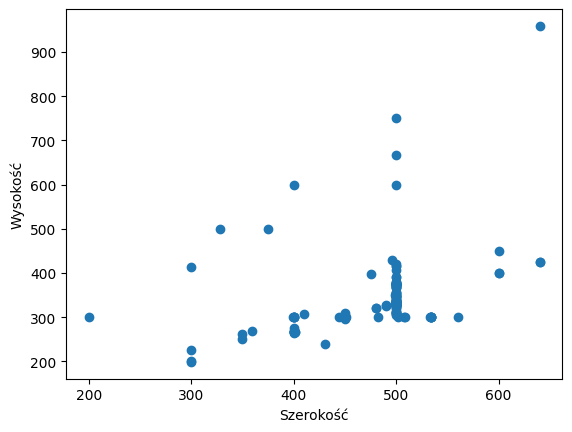

In [ ]:
plt.xlabel("Szerokość")
plt.ylabel("Wysokość")
plt.scatter(widths, heights)

In [ ]:
image_count_by_size = dict()

In [ ]:
for image in coco.dataset["images"]:
  w = image["width"]
  h = image["height"]
  if w <= 700:
    # grupujemy
    image_size = (-1, -1)
    image_count_by_size[image_size] = image_count_by_size.get(image_size, 0) + 1
  else:
    image_size = (h, w)
    image_count_by_size[image_size] = image_count_by_size.get(image_size, 0) + 1

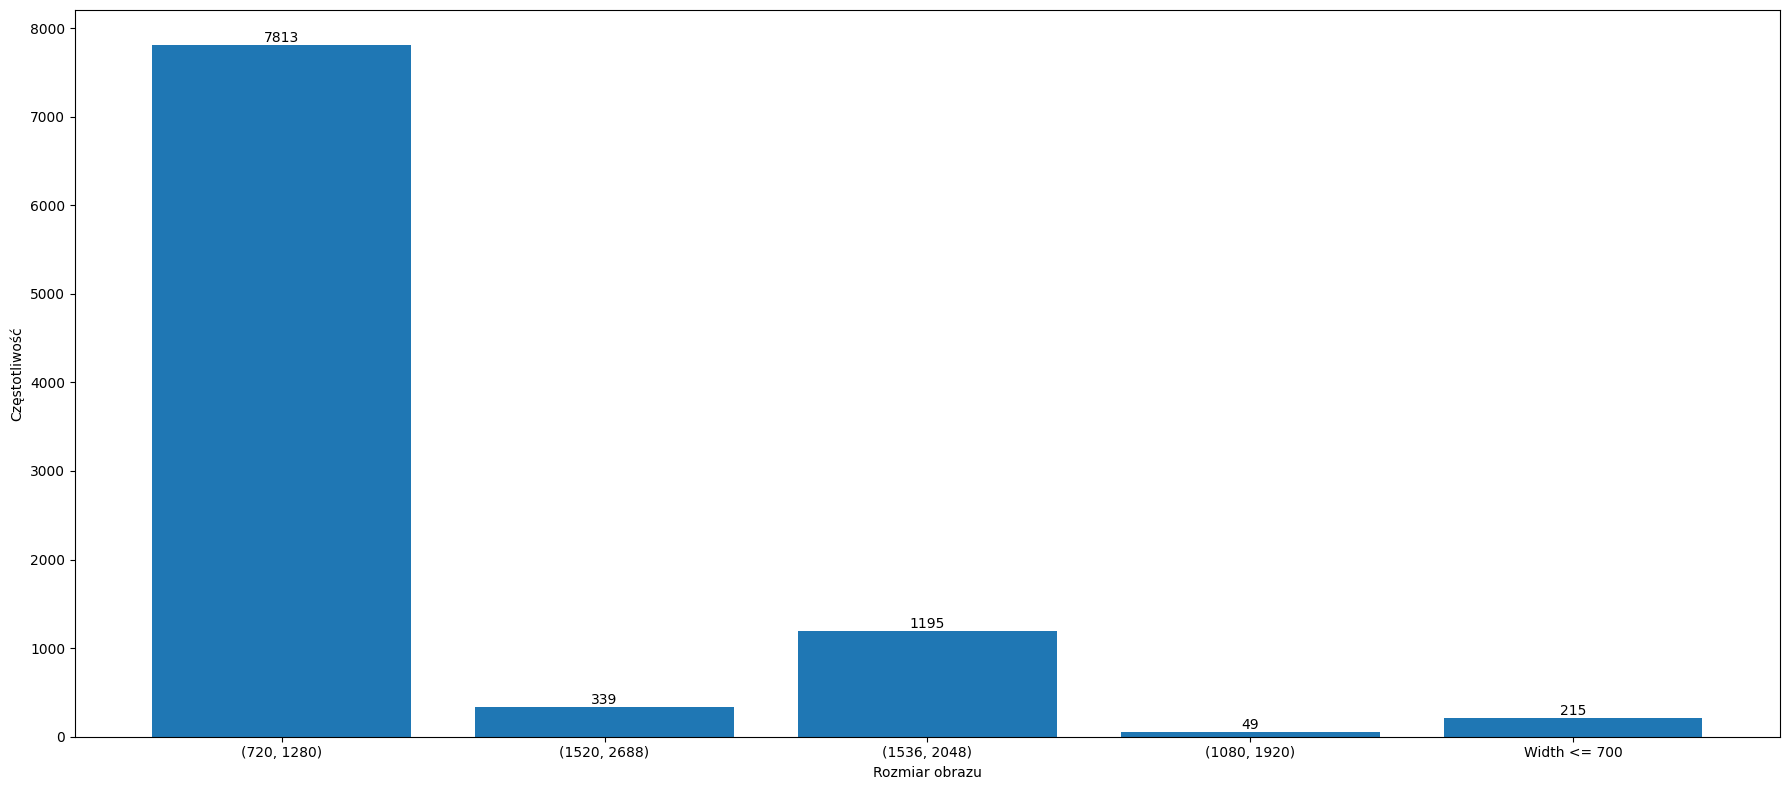

In [ ]:
categories = list(str(size) if size != (-1, -1) else "Width <= 700" for size in image_count_by_size.keys())
counts = list(image_count_by_size.values())

plt.figure(figsize=(18, 8))
plt.bar(categories, counts)
plt.xlabel("Rozmiar obrazu")
plt.ylabel("Częstotliwość")
plt.title("")


for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Fakty
* Rozmiar 720x1280 dominuje w zbiorze. Może to prowadzić do problemów w postaci niższej skuteczności jeżeli model będzie operował na obrazach o innych wymiarach (już po wdrożeniu modelu do produkicji).
* Mamy również sporo obrazów 1536x2048 - urozmaici to trening i może być korzystne.
* Podczas tworzenia tzw. anchor boxów (występujących w YOLO) należy wziąć pod uwagę różnorodność wymiarów obrazów i dostosować wymiary anchor boxów, aby pokrywały wszystkie wielkości.

### Możliwe ulepszenia
* Najbardziej popularnym podejściem jest zmiana wielkości obrazów już podczas treningu (jako warstwa w modelu). Różnorodność w wymiarach może przynieść dużo więcej korzystnych skutków niż negatywnych.

## 2.3 Ilość zaznaczeń na jednym obrazie

In [ ]:
objects_count_per_image = dict()

In [ ]:
for image in coco.dataset["images"]:
    annotation_ids = coco.getAnnIds(imgIds=image["id"])
    count = len(annotation_ids)
    objects_count_per_image[count] = objects_count_per_image.get(count, 0) + 1

In [ ]:
print(objects_count_per_image)

{1: 4813, 2: 2211, 3: 1078, 4: 813, 7: 76, 5: 384, 6: 201, 9: 8, 8: 20, 10: 4, 12: 2, 13: 1}


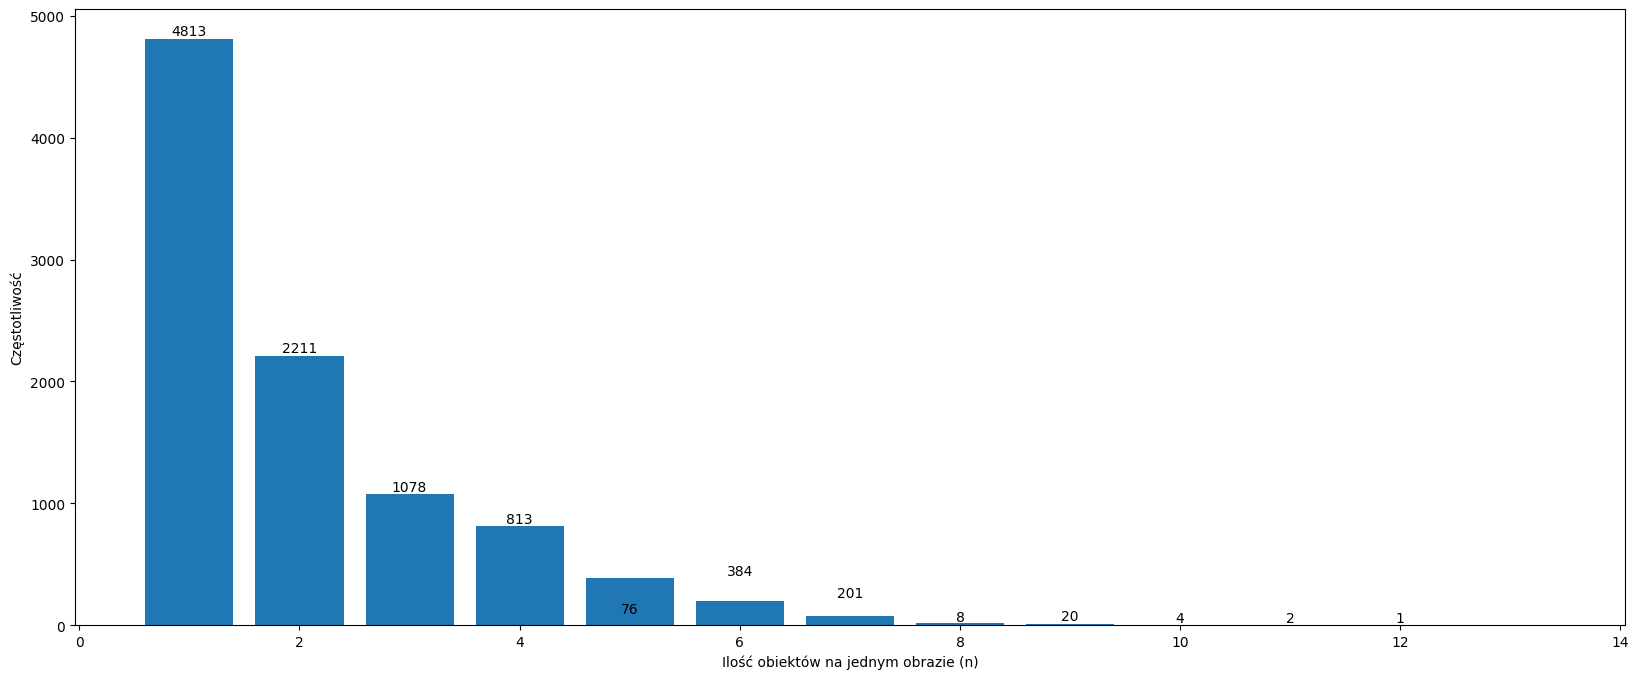

In [ ]:
categories = list(objects_count_per_image.keys())
counts = list(objects_count_per_image.values())

plt.figure(figsize=(20, 8))
plt.bar(categories, counts)
plt.xlabel("Ilość obiektów na jednym obrazie (n)")
plt.ylabel("Częstotliwość")

for i, count in enumerate(counts):
  plt.text(i + 1, count, str(count), ha='center', va='bottom')

plt.show()

### Fakty
* 4813 zdjęć zawiera tylko jeden przedmiot. Jest to najłatwiejszy przypadek dla algorytmu wykrywającego obiekty i jest dobrym punktem początkowym. Tak duża ilość obrazów z jedną klasą może okazać się problematyczna, gdy będziemy wymagać od modelu aby sprawnie wykrywał więcej przedmiotów na jednym zdjęciu.
* 2211 zdjęć z dwoma klasami.
* Mało zdjęć z większą ilością obiektów do wykrycia na jednej fotografii.
* Model wyćwiczony na takim zbiorze może mieć problemy z wykrywaniem obiektów na zdjęciach z dużą ilością klas.

### Możliwe ulepszenia
* Można zebrać więcej danych. W szczególności zdjęc, na których jest więcej klas, aby polepszyć wydajność modelu w takich przypadkach.
* Sztuczne tworzenie nowych danych - dodawanie przedmiotów (np. gogli) w programie graficznym.
* Lepsze opisanie istniejących już danych. Wspomniane w 2.1


## 2.4 Rozmieszczenie oraz wielkość zaznaczeń

Przy analizie rozmieszczenia zaznaczeń musimy zwrócić uwagę na różne rozmiary zdjęć. Jako rozwiązanie zastosuję prostą proporcję, tzn. każde rozmieszczenie przedstawię na wykresie 100 x 100, a pozycje zaznaczeń znormalizuje wedle wzoru:
$$ x_{zaznaczenia} := \frac{x_{zaznaczenia}}{w_{obrazu}}$$
Analogicznie dla y.
Zdjęcia nie są co prawda kwadratami (przedstawiamy rozmieszczenia na planszy 100x100) ale to uproszczenie nie wpłynie na naszą analizę.

In [ ]:
x = []
y = []

for annotation in coco.dataset["annotations"]:
    img_id = annotation["image_id"]
    img = coco.loadImgs(img_id)[0]
    bbox = annotation["bbox"]
    x_ = bbox[0]
    y_ = bbox[1]
    w = img["width"]
    h = img["height"]
    x_normalized = x_ / w
    y_normalized = y_ / h
    x.append(x_normalized)
    y.append(y_normalized)

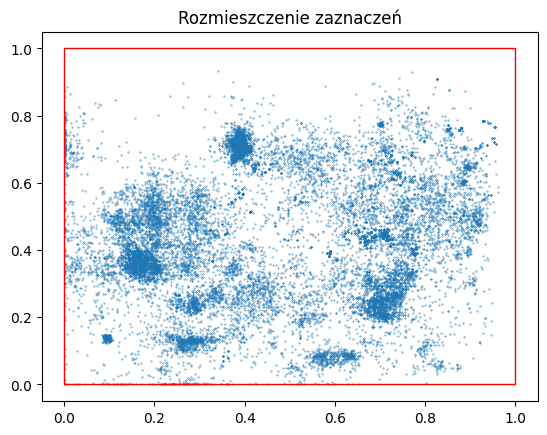

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y, s=0.1)

ax.add_patch(patches.Rectangle(xy=(0, 0),
        width=1, height=1, linewidth=1,
        color='red', fill=False))
plt.title("Rozmieszczenie zaznaczeń")
plt.show()

In [ ]:
bounding_boxes = []

for annotation in coco.dataset["annotations"]:
    bbox = annotation["bbox"]
    bounding_boxes.append(bbox)

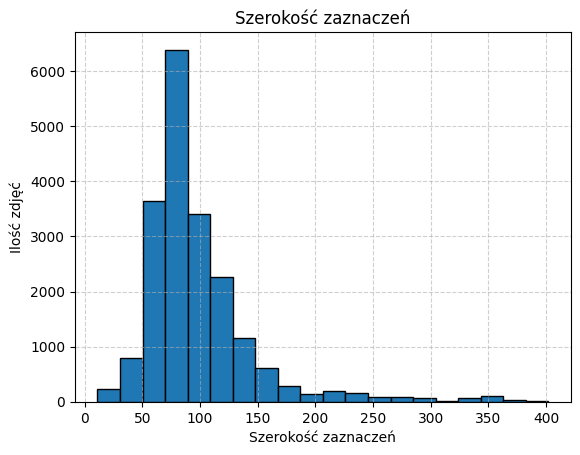

In [ ]:
widths = [bbox[2] for bbox in bounding_boxes]

plt.hist(widths, bins=20, edgecolor='black')
plt.xlabel('Szerokość zaznaczeń')
plt.ylabel('Ilość zdjęć')
plt.title('Szerokość zaznaczeń')
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.show()

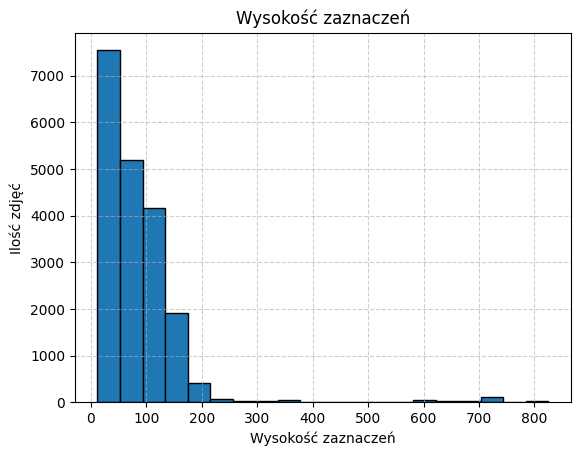

In [ ]:
heights = [bbox[3] for bbox in bounding_boxes]

plt.hist(heights, bins=20, edgecolor='black')
plt.xlabel('Wysokość zaznaczeń')
plt.ylabel('Ilość zdjęć')
plt.title('Wysokość zaznaczeń')
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.show()

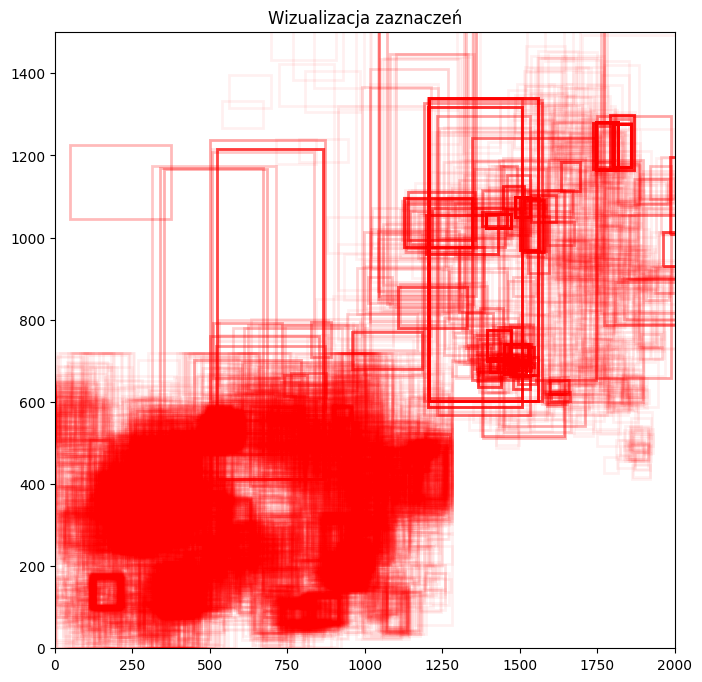

In [ ]:
canvas = plt.figure(figsize=(8, 8))
ax = canvas.add_subplot(111)

for bbox in bounding_boxes:
    x, y, width, height = bbox
    rect = plt.Rectangle((x, y), width, height, linewidth=2, edgecolor=(1, 0, 0, 0.06), facecolor='none')
    ax.add_patch(rect)


ax.set_xlim(0, 2000)
ax.set_ylim(0, 1500)


plt.title('Wizualizacja zaznaczeń')
plt.show()

Na powyższej wizualizacji widzimy zaznaczenia dla każdego rozmiaru zdjęć przez co np. lewy dolny róg planszy jest mocno zapełniony ze względu na znaczną przewagę obrazów o rozmiarze 720x1280 w zbiorze danych. Dlatego, aby ułatwić wyciąganie wniosków przedstawię zaznaczenia dla dwóch rozmiarów obrazów, 720x1280 (81% wszystkich zdjęć) oraz 1536x2048 (12% wszystkich zdjęć).

720x1280

In [ ]:
bounding_boxes_720 = []

for annotation in coco.dataset["annotations"]:
    img_id = annotation["image_id"]
    img = coco.loadImgs(img_id)[0]
    w = img["width"]
    h = img["height"]
    if (h, w) == (720, 1280):
      bbox = annotation["bbox"]
      bounding_boxes_720.append(bbox)

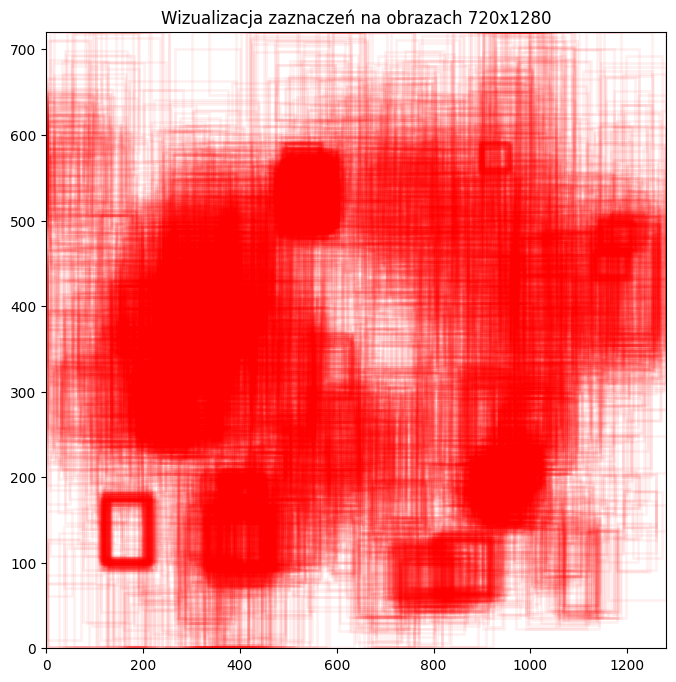

In [ ]:
canvas = plt.figure(figsize=(8, 8))
ax = canvas.add_subplot(111)

for bbox in bounding_boxes_720:
    x, y, width, height = bbox
    rect = plt.Rectangle((x, y), width, height, linewidth=2, edgecolor=(1, 0, 0, 0.06), facecolor='none')
    ax.add_patch(rect)


ax.set_xlim(0, 1280)
ax.set_ylim(0, 720)

plt.title('Wizualizacja zaznaczeń na obrazach 720x1280')
plt.show()

1536x2048

In [ ]:
bounding_boxes_1536 = []

for annotation in coco.dataset["annotations"]:
    img_id = annotation["image_id"]
    img = coco.loadImgs(img_id)[0]
    w = img["width"]
    h = img["height"]
    if (h, w) == (1536, 2048):
      bbox = annotation["bbox"]
      bounding_boxes_1536.append(bbox)

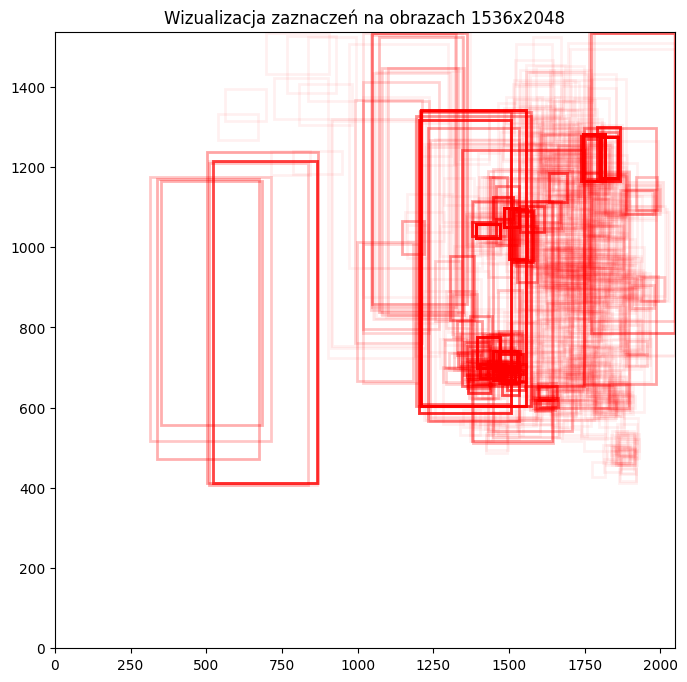

In [ ]:
canvas = plt.figure(figsize=(8, 8))
ax = canvas.add_subplot(111)

for bbox in bounding_boxes_1536:
    x, y, width, height = bbox
    rect = plt.Rectangle((x, y), width, height, linewidth=2, edgecolor=(1, 0, 0, 0.06), facecolor='none')
    ax.add_patch(rect)


ax.set_xlim(0, 2048)
ax.set_ylim(0, 1536)


plt.title('Wizualizacja zaznaczeń na obrazach 1536x2048')
plt.show()

Nakładające się na siebie zaznaczenia

In [ ]:
overlapping_objects_per_image = {}

In [ ]:
for image in coco.dataset["images"]:
  image_id = image["id"]
  annotation_ids = coco.getAnnIds(imgIds = image_id, catIds = category_ids) # zwraca listę id adnotacji
  annotations = coco.loadAnns(annotation_ids) # zwraca listę dictów zawierających info na temat danej adnotacji
  boxes = []
  for annotation in annotations:
      bbox = annotation["bbox"]
      boxes.append(bbox)
  # sprawdzamy ile zaznaczeń nachodzi na siebie
  n = len(boxes)
  overlap_count = 0
  for i in range(n):
    x1 = boxes[i][0]
    y1 = boxes[i][1]
    w = boxes[i][2]
    h = boxes[i][3]
    x2 = x1 + w
    y2 = y1 + h
    for j in range(i + 1, n):
      x3 = boxes[j][0]
      y3 = boxes[j][1]
      w_ = boxes[j][2]
      h_ = boxes[j][3]
      x4 = x3 + w_
      y4 = y3 + h_
      if (x1 < x4) and (x2 > x3) and (y3 < y2) and (y1 > y4):
        overlap_count += 1
  overlapping_objects_per_image[overlap_count] = overlapping_objects_per_image.get(overlap_count, 0) + 1

In [ ]:
print(overlapping_objects_per_image)

{0: 9109, 1: 381, 2: 77, 5: 5, 3: 15, 6: 7, 4: 11, 8: 4, 9: 2}


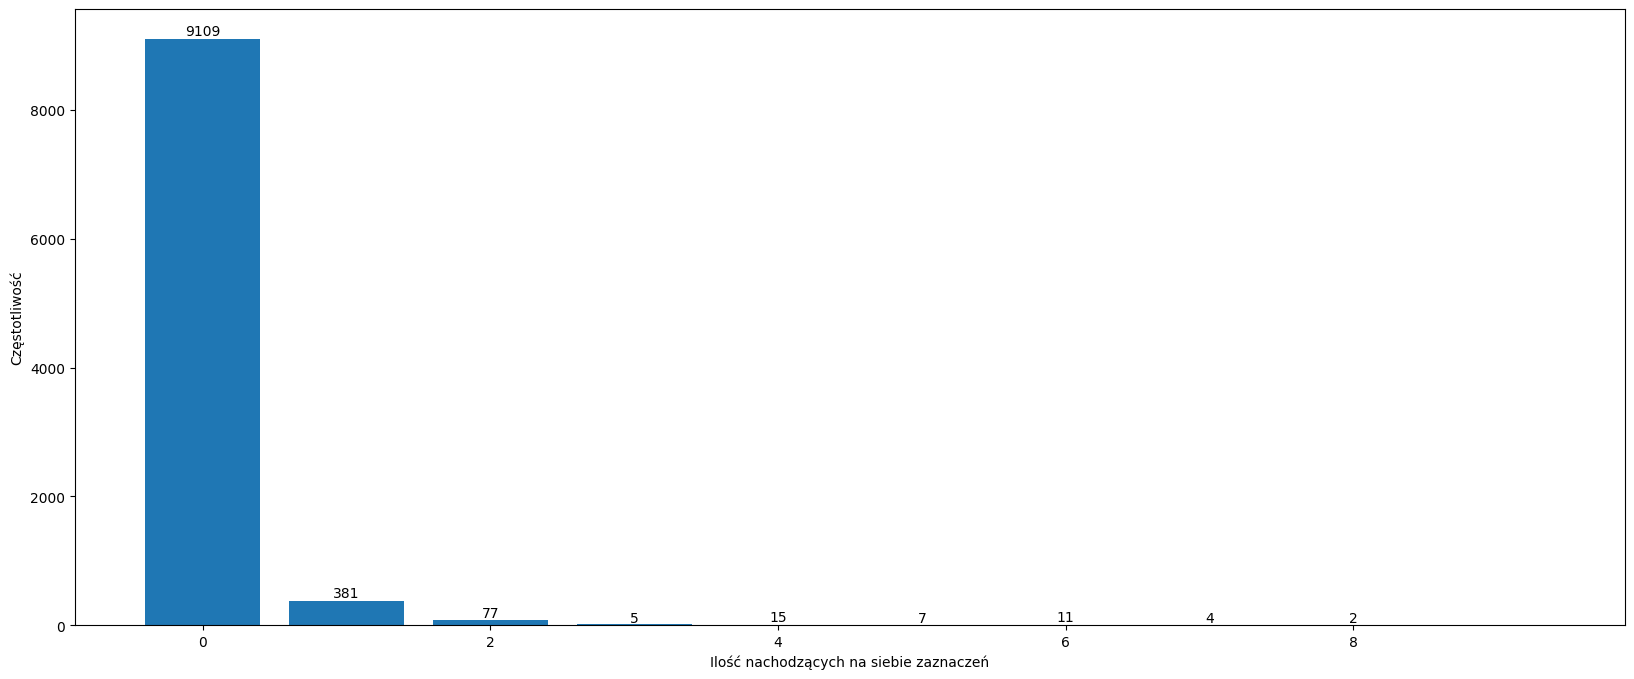

In [ ]:
categories = list(overlapping_objects_per_image.keys())
counts = list(overlapping_objects_per_image.values())

plt.figure(figsize=(20, 8))
plt.bar(categories, counts)
plt.xlabel("Ilość nachodzących na siebie zaznaczeń")
plt.ylabel("Częstotliwość")

for i, count in enumerate(counts):
  plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

### Fakty
* Rozmieszczenie zaznaczeń jest bardzo zbalansowane w przypadku obrazów 720x1280.
* Mniej zbalansowane jest rozmieszczenie w przypadku obrazów 1536x2048 (drugi najbardziej liczny rozmiar). Zaznaczenia występują głównie w prawym górnym rogu i w ogóle nie występują w dolnej części zdjęć. Jako drugi najbardziej popularny rozmiar, te obrazy mają dość spory wpływ na trening modelu.
* Ilość zaznaczeń o poszczególych rozmiarach jest ścisle związana z balansem klas. Mamy dużo więcej gogli i rękawic na zdjęciach, dlatego dominują zaznaczenia o małych wymiarach. Dodając więcej przykładów z fartuchami zmiejszymy dysproporcję pomiędzy ilością zaznaczeń o relatywnie małych wymiarach a relatywnie dużych wymiarach.
* Znikoma ilość obrazów gdzie zaznaczenia na siebie nachodzą. Około 500 obrazów gdzie występują nakładające się zaznaczenia to prawdopodobnie za mała ilość aby model dobrze radził sobie z takimi sytuacjami.

### Możliwe ulepszenia
* Zebrać więcej zdjęć o wymiarach 1536x2048 gdzie będą występować obiekty w innych niż dotychczas miejscach.
* Sztuczne tworzenie danych w przypadku obrazów o wymiarach 1536x2048 pozwoli dodać obiekty do wykrycia w rejonach zdjęć gdzie zaznaczenia nie występują. Można to osiągnąć poprzez zastosowanie lustrzanego odbicia (wtedy zapełnimy lewą część) lub wklejenie obiektów (człowiek + klasa do wykrycia) w programie graficznym.
* Zebrać więcej danych gdzie klasy na siebie nachodzą.

## 2.5 Jakość zaznaczeń

Aby ocenić jakość zaznaczeń należy ręcznie przejrzeć część obrazów i związanych z nimi bounding boxów.

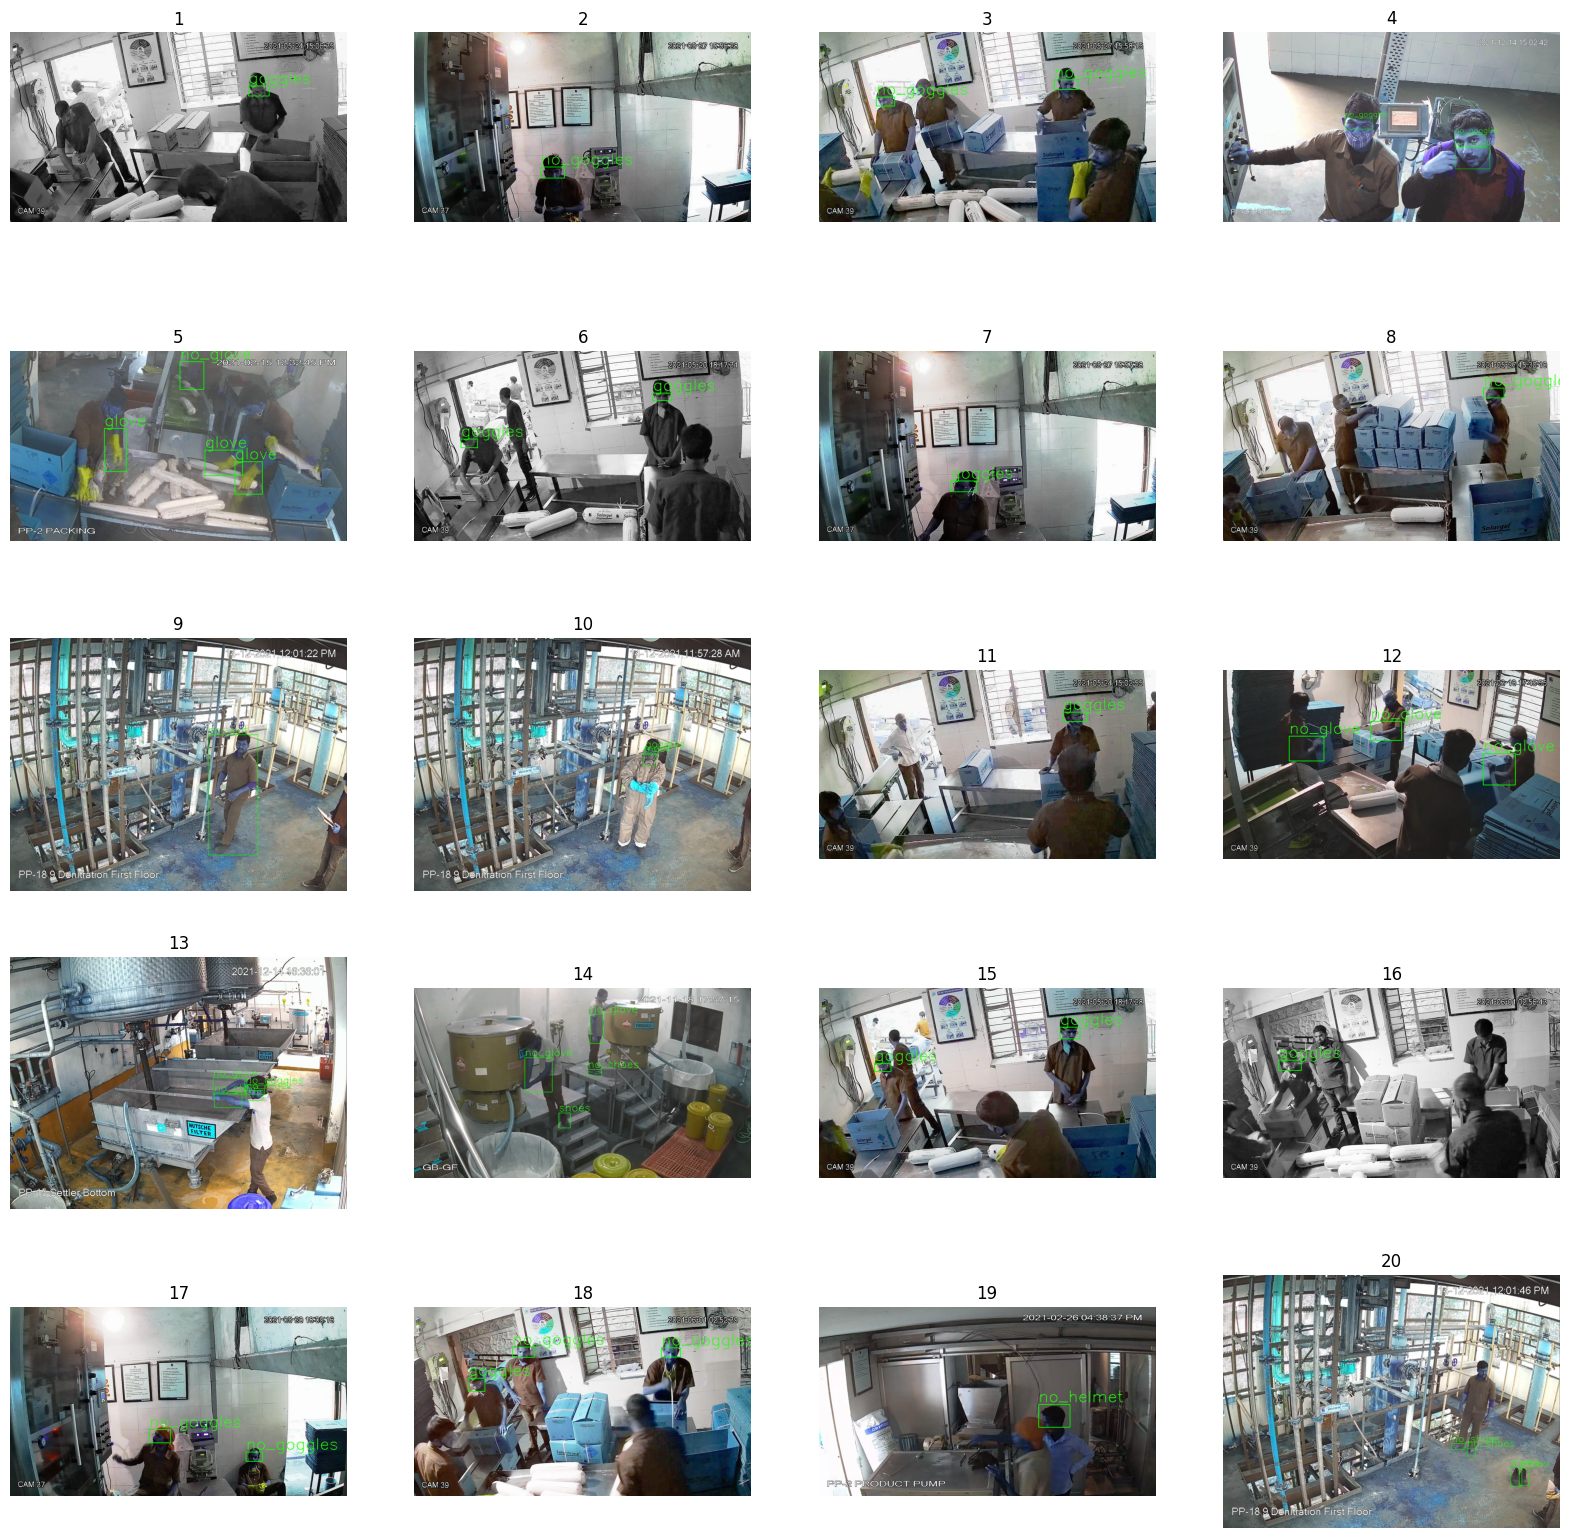

In [ ]:
# https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure


fig = plt.figure(figsize=(20, 20))
columns = 4
rows = 5

random.seed(10) # aby po załadowaniu notebooka od nowa obrazy wyświetlane po niżej się nie zmieniły, ale nadal były losowo wybrane
random_image_ids = random.sample(range(0, num_images), columns * rows) # generuje n losowych ID od 0 do num_images - 1

id = 0
for i in range(1, columns * rows + 1):
    image_id = coco.loadImgs(id)[0]["id"]
    image_file_name = coco.loadImgs(id)[0]["file_name"]
    image_path = os.path.join(images_directory, image_file_name)
    image = cv2.imread(image_path)

    annotation_ids = coco.getAnnIds(imgIds = image_id, catIds = category_ids) # zwraca listę id adnotacji
    annotations = coco.loadAnns(annotation_ids) # zwraca listę dictów zawierających info na temat danej adnotacji
    for annotation in annotations:
      bbox = annotation["bbox"]

      category_id = annotation["category_id"] # 0, 1, ...
      category_str = id_to_category[category_id] # glove, goggles, ...

      cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])), (0, 255, 0), 2) # nakłada bounding box na obraz

      cv2.putText(image, category_str, (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (36,255,12), 2) # podpisuje box odpowiednią kategorią

    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(image)
    plt.title(id + 1)
    id += 1
plt.show()

### Fakty
* Zaznaczenia zdają się być dokładne, tzn. obiekty są precyzyjnie oznaczone i idealnie wpasowują się w obrys bounding boxów.
* Praktycznie nie występują zaznaczenia które nachodziłyby na siebie. Model potencjalnie może mieć problemy z wykrywaniem takich obiektów, np. gogle i maska założone równocześnie.
* Potwierdza się przypuszczenie powstałe po pierwszej inspekcji zdjęć. Duża część zdjęć ma nieoznaczone obiekty, np. na zdjęciu 11. nie oznaczono "no_helmet", "no_glove"; na 10. nie oznaczono "glove" itd.
* Pomieszczenia na fotografiach zdają się powtarzać, może pojawić się problem z rozpoznawaniem na innych tłach (w innych pomieszczeniach, których model nie "widział" podczas treningu).

# 3. Validation dataset analiza

Ważne aby te obrazy jak najbardziej odzwierciedlały te, które będą finalnie używane w produkcji.

In [ ]:
annotations_file = "/content/valid/_annotations.coco.json"
images_directory = "/content/valid"

In [ ]:
coco = COCO(annotations_file)

loading annotations into memory...
Done (t=1.58s)
creating index...
index created!


In [ ]:
num_images = len(coco.getImgIds()) # ilość obrazów
print(num_images)

2367


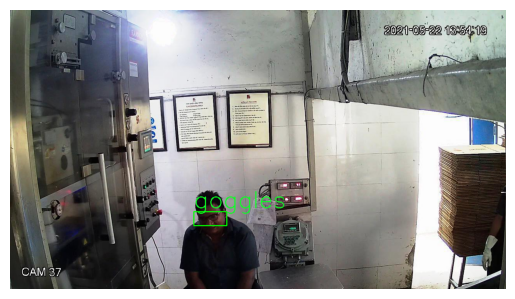

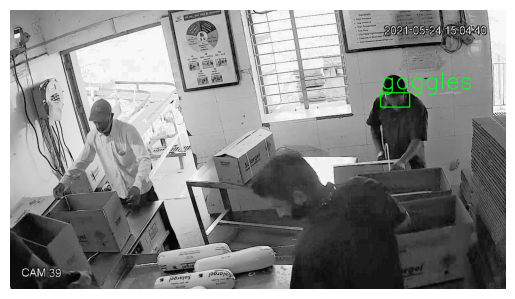

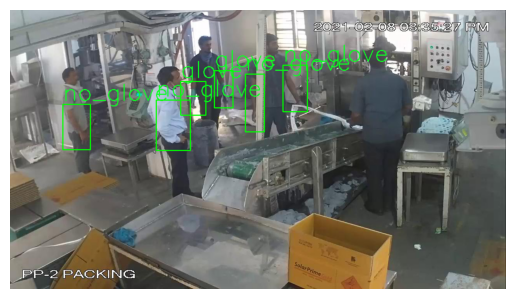

In [ ]:
random_image_ids = random.sample(range(0, num_images), 3) # generuje n losowych ID od 0 do num_images - 1


for id in random_image_ids: # iteruje przez wszystkie losowo wygenerowane id
  # info na temat adnotacji oraz ścieżka do wyświetlenia obrazu
  image_id = coco.loadImgs(id)[0]["id"]
  image_file_name = coco.loadImgs(id)[0]["file_name"]
  image_path = os.path.join(images_directory, image_file_name)
  image = cv2.imread(image_path)


  annotation_ids = coco.getAnnIds(imgIds = image_id, catIds = category_ids) # zwraca listę id adnotacji
  annotations = coco.loadAnns(annotation_ids) # zwraca listę dictów zawierających info na temat danej adnotacji
  for annotation in annotations:
    bbox = annotation["bbox"]

    category_id = annotation["category_id"] # 0, 1, ...
    category_str = id_to_category[category_id] # glove, goggles, ...

    cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])), (0, 255, 0), 2) # nakłada bounding box na obraz

    cv2.putText(image, category_str, (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (36,255,12), 2) # podpisuje box odpowiednią kategorią

  # wyświetla obraz z bboxami
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

Zdjęcia wyglądają na pochodzące z tej samej dystrybucji co treningowe.

In [ ]:
objects_count = {key : 0 for key in id_to_category[1:]}

In [ ]:
for annotation in coco.dataset["annotations"]:
    category_id = annotation["category_id"]
    category_str = id_to_category[category_id]

    objects_count[category_str] += 1
print(objects_count)

{'glove': 958, 'goggles': 823, 'helmet': 283, 'mask': 58, 'no-suit': 15, 'no_glove': 1241, 'no_goggles': 799, 'no_helmet': 229, 'no_mask': 137, 'no_shoes': 143, 'shoes': 185, 'suit': 18}


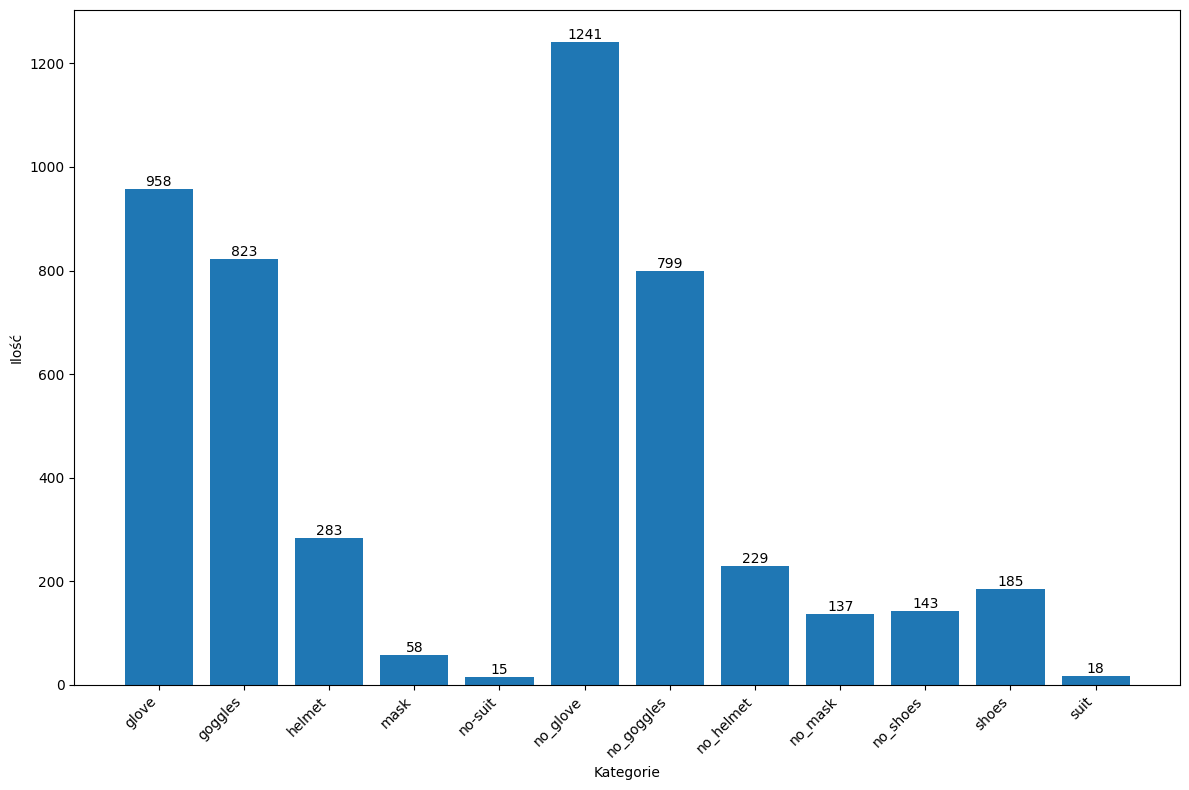

In [ ]:
categories = list(objects_count.keys())
counts = list(objects_count.values())

# https://matplotlib.org/stable/tutorials/pyplot.html

plt.figure(figsize=(12, 8))
plt.bar(categories, counts)
plt.xlabel("Kategorie")
plt.ylabel("Ilość")
plt.title("")

plt.xticks(rotation=45, ha='right')

for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Proporcje w ilości klas są bardzo podobne do tych w zbiorze treningowym.

# 4. Podsumowanie

*\"Czy przygotowany przez zespół tworzący adnotacje zdjęć, zbiór jest wystarczający, aby uruchomić trening?\"*

Zbiór jest wystarczający, aby uruchomić trening. Trening modelu to bardzo iteratywny proces i praktycznie zawsze jest coś do poprawy w zbiorze danych (chociażby więcej danych). Dzięki wczesnemu uruchomieniu treningu (nawet gdy dane nie są tak dobre jak mogłyby być) zyskamy dodatkowe cenne informacje - co działa, a co nie działa. Wtedy będzie można podjąć kolejne kroki i stopniowo polepszać zbiór danych wedle zaleceń podanych w sekcjach "Możliwe ulepszenia". Możliwe jest również, że przy odpowiednio dobranej architekturze modelu i umiarkowanie skomplikowanym zastowaniu wydajność modelu będzie zadowolająca i dalsze działania w obrębie zbiory danych nie będą konieczne.
### Kolejne kroki
* Zaczęcie od mniej skomplikowanej architektury niż mogłoby się wydawać, przyśpieszy to iteracje na początku i może spełnić oczekiwania
* Zastosowanie sprawdzonej architektury i transfer learningu
* Zastosowanie sztucznego generowania danych jako warstwy w modelu (data augmentation)